In [101]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import imutils
import shutil
from sklearn.utils import shuffle
import os

In [102]:
def crop_brain_contour(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 

    return new_image

In [103]:

TRINING_DIR = "C:\\Users\\X1\\Desktop\\master - S3\\image-mining\\data\\data\\Training"
TEST_DIR = "C:\\Users\\X1\\Desktop\\master - S3\\image-mining\\data\\data\\Testing"
image_size = 128
def readDataSet(dirr):
    data = []
   
    yes_path = os.path.join(dirr, "yes")
    for file in os.listdir(yes_path):
        image = cv2.imread(os.path.join(yes_path, file))
        img = crop_brain_contour(image)
        img = cv2.resize(img,(image_size,image_size))
        data.append((img,1))
        
    no_path = os.path.join(dirr, "no")
    for f in os.listdir(no_path):
        image = cv2.imread(os.path.join(no_path, f))
        img = crop_brain_contour(image)
        image = cv2.resize(img,(image_size,image_size))
        data.append((image,0))
      
    return data 
          
train_dataset  = shuffle(readDataSet(TRINING_DIR))
test_dataset = shuffle(readDataSet(TEST_DIR))
print("training dataset lenght : ",len(train_dataset) )
print("test dataset lenght : ",len(test_dataset) )

training dataset lenght :  2953
test dataset lenght :  409


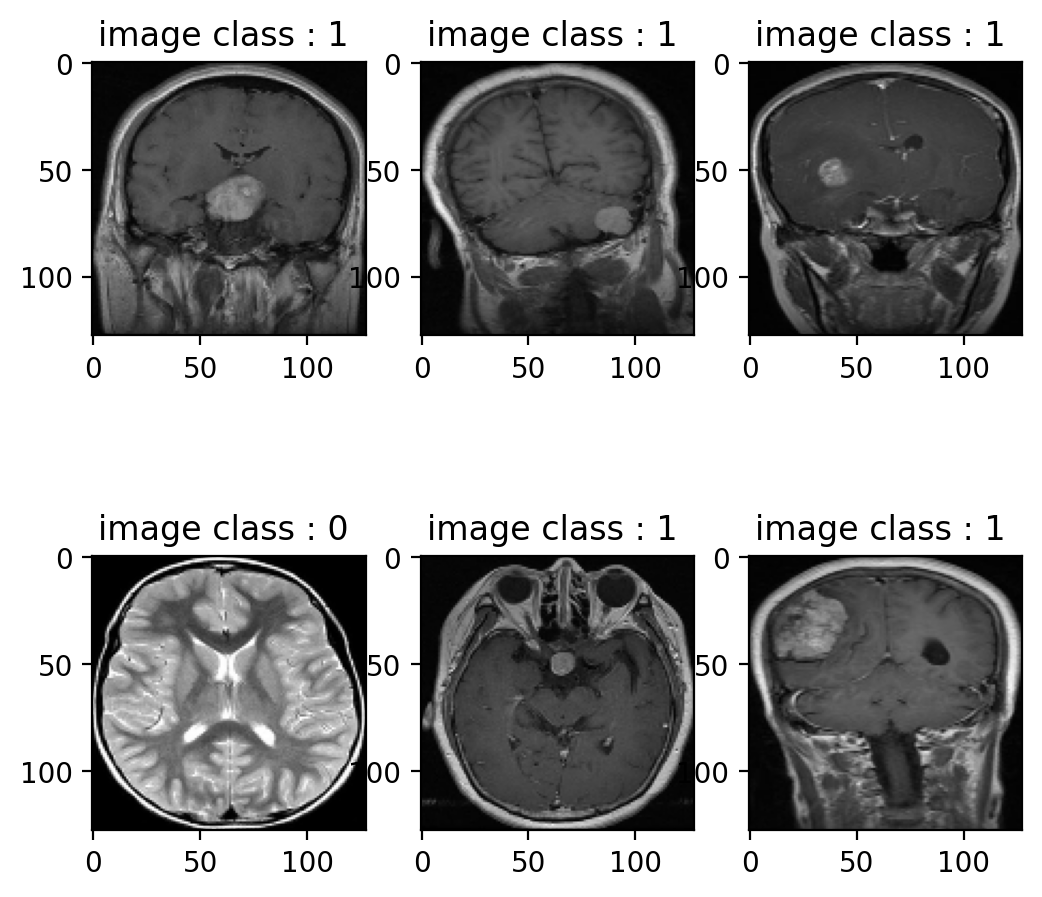

In [104]:
fig = plt.figure(figsize=(6, 6), dpi=200)
index = random.sample(range(len(train_dataset)), 6)
for i in range(6):
    ax1 = fig.add_subplot(2, 3, i+1)
    ax1.imshow(train_dataset[index[i]][0])
    ax1.set_title('image class : %s '% (train_dataset[index[i]][1]))


In [105]:
X_train = []
Y_train = []
for tupl in train_dataset:
    X_train.append(tupl[0])
    Y_train.append(tupl[1])
X_train = np.array(X_train)
Y_train = np.array(Y_train).reshape(-1)
    
X_test = []
Y_test = []
for tupl in test_dataset:
    X_test.append(tupl[0])
    Y_test.append(tupl[1])
X_test = np.array(X_test)
Y_test = np.array(Y_test).reshape(-1)


In [106]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#inception_model = InceptionV3(input_shape = (image_size,image_size, 3), include_top=False,weights = 'imagenet')
resnet_model = tf.keras.applications.ResNet50(input_shape = (image_size,image_size, 3), include_top=False,weights = 'imagenet')

model = tf.keras.models.Model(resnet_model.input, resnet_model.output)


In [107]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [108]:
# features extraction
def extractAllFeatures(dataset):
    X = []
    Y = []
    for i in range(len(dataset)):
        image = dataset[i][0].reshape(1,image_size,image_size,3)
        image = tf.keras.applications.resnet.preprocess_input(image)
        feature = model.predict(image)
        X.append(feature.reshape(-1))
        Y.append(dataset[i][1])
    return np.array(X),np.array(Y).reshape(-1) 


X_train , Y_train = extractAllFeatures(train_dataset)
X_test , Y_test = extractAllFeatures(test_dataset)
print("X_train : ", X_train.shape ," ,  Y_train : ", Y_train.shape)
print("X_test : ", X_test.shape ," ,  Y_test : ", Y_test.shape)

X_train :  (2953, 32768)  ,  Y_train :  (2953,)
X_test :  (409, 32768)  ,  Y_test :  (409,)


In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def Log_transform(mat):
    mat = mat - mat.min() + 1
    return np.log(mat)   
    
def fillingEmptyValue(xmat):
    im = SimpleImputer(missing_values=np.nan, strategy="mean", fill_value=None, verbose=0, copy=True)
    xmat = im.fit_transform(xmat)
    return xmat

X_train = fillingEmptyValue(X_train)
X_train = Log_transform(X_train)

X_test = fillingEmptyValue(X_test)
X_test = Log_transform(X_test)

print("X_train : ", X_train.shape ," ,  Y_train : ", Y_train.shape)
print("X_test : ", X_test.shape ," ,  Y_test : ", Y_test.shape)

X_train :  (2953, 32768)  ,  Y_train :  (2953,)
X_test :  (409, 32768)  ,  Y_test :  (409,)


In [110]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, Y_train) 

y_pred = svclassifier.predict(X_test) 
######################## Evaluating the Algorithm ########################
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print("SVM accueacy : ",accuracy_score(Y_test,y_pred))

[[104   7]
 [ 26 272]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       111
           1       0.97      0.91      0.94       298

    accuracy                           0.92       409
   macro avg       0.89      0.92      0.90       409
weighted avg       0.93      0.92      0.92       409

SVM accueacy :  0.9193154034229829


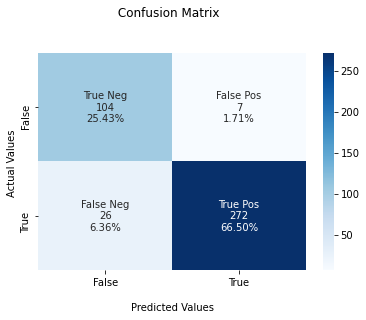

In [111]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix   \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [112]:

from sklearn.decomposition import PCA
def applyPCA(matt):
    pca = PCA(n_components = 0.95)
    pca.fit(matt)
    matt = pca.transform(matt)
    return matt

full_data_x = np.concatenate((X_train, X_test), axis=0)
full_data_y = np.concatenate((Y_train, Y_test), axis=0)
full_data_x = applyPCA(full_data_x)

print("X_train : ", full_data_x.shape ," ,  Y_train : ", full_data_y.shape)

######################### Split train+test #######################################
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(full_data_x, full_data_y, test_size = 0.20,random_state=2)

X_train :  (3362, 1749)  ,  Y_train :  (3362,)


In [113]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, Y_train) 

y_pred = svclassifier.predict(X_test) 
######################## Evaluating the Algorithm ########################
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print("SVM accueacy : ",accuracy_score(Y_test,y_pred))


[[107   8]
 [  2 556]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       115
           1       0.99      1.00      0.99       558

    accuracy                           0.99       673
   macro avg       0.98      0.96      0.97       673
weighted avg       0.99      0.99      0.98       673

SVM accueacy :  0.9851411589895989


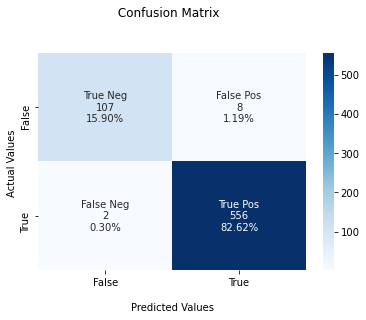

In [114]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(Y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(' Confusion Matrix   \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()